In [48]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from random import random, randint
from sklearn.utils import shuffle
import pandas as pd
import os
import cv2
from datetime import datetime


# ran the bit of code below to get the count of images and the largest
# image dimensionality.

# totfiles = 0
# maxdim = 0
# for subdir, dirs, files in os.walk(rootdir):
#     for file in files:
#         if not(len(files) == 1 and files[0] == '.DS_Store'):
#             totfiles += 1
#             filewithpath = subdir + '/' + file
#             im = cv2.imread(filewithpath, cv2.IMREAD_COLOR)
#             currdim = im.shape[0] * im.shape[1] * im.shape[2]
#             if totfiles % 1000 == 0:
#                 print(totfiles)
#             if currdim > maxdim:
#                 maxdim = currdim

# totfiles = 15336
# maxdim = 413952

# no need to run the above code each time to get the file count
def getbeandata(squareside = 50):
    rootdir = '/Users/user1/OneDrive/OneDrive iOS/' \
        '_course_sirajMLmakemoney/week7/dataset'
    
    
    N = 15336
    D = squareside ** 2

    X = np.zeros((N, D))
    Y = np.zeros(N)

    currimg = 0
    picclasses = {}
    totclasses = 0
    t0 = datetime.now()
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if not(len(files) == 1 and files[0] == '.DS_Store'):
                filewithpath = subdir + '/' + file
                picclass = subdir.split('/')[-1]
                if picclass not in picclasses.keys():
                    picclasses[picclass] = (totclasses, picclass)
                    totclasses += 1
                filewithpath = subdir + '/' + file
                im = cv2.imread(filewithpath, cv2.IMREAD_GRAYSCALE)
                im = cv2.resize(im, (squareside, squareside))
                im = np.reshape(im, -1)
                im = im / 255
                Y[currimg] = picclasses[picclass][0]
                X[currimg, :im.shape[0]] = im
                if currimg % 100 == 0:
                    t1 = datetime.now()
                    print(currimg, t1 - t0)
                    t0 = t1
                currimg += 1
    
    return X, Y, picclasses


def init_weight_and_bias(M1, M2):
    W = np.random.randn(M1, M2) / np.sqrt(M1)
    b = np.zeros(M2)
    return W.astype(np.float32), b.astype(np.float32)


def init_filter(shape, poolsz):
    w = np.random.randn(*shape) * np.sqrt(2) / np.sqrt(
        np.prod(shape[1:]) + shape[0] * np.prod(shape[2:] / np.prod(poolsz)))
    return w.astype(np.float32)


def relu(x):
    return x * (x > 0)


def sigmoid(A):
    return 1 / (1 + np.exp(-A))


def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)


def sigmoid_cost(T, Y):
    return -(T * np.log(Y) + (1 - T) * np.log(1 - Y)).sum()


def cost(T, Y):
    return -(T * np.log(Y)).sum()

def error_rate(targets, predictions):
    return np.mean(targets != predictions)


def y2indicator(y):
    N = len(y)
    K = len(set(y))
    ind = np.zeros((N, K + 1))
    for i in range(N):
#         print('i: ', i, ' y[i]: ', y[i])
        ind[i, int(y[i])] = 1
    ind = ind.astype(int)
    return ind


def getData(balance_ones=False):
    # images are 48x48 = 2304 size vectors
    X = np.genfromtxt('data/X.csv', delimiter=',')
    X = np.array(X) / 255.0

    Y = np.genfromtxt('data/Y.csv', delimiter=',')

    if balance_ones:
        # balance the 1 class
        X0, Y0 = X[Y != 1, :], Y[Y != 1]
        X1 = X[Y == 1, :]
        X1 = np.repeat(X1, 9, axis=0)
        X = np.vstack([X0, X1])
        Y = np.concatenate((Y0, [1] * len(X1)))

    return X, Y


def getImageData():
    X, Y = getData()
    N, D = X.shape
    d = int(np.sqrt(D))
    X = X.reshape(N, 1, d, d)
    return X, Y


def getBinaryData():
    Y = []
    X = []
    first = True
    for line in open('data/fer2013.csv'):
        if first:
            first = False
        else:
            row = line.split(',')
            y = int(row[0])
            if y == 0 or y == 1:
                Y.append(y)
                X.append([int(p) for p in row[1].split()])
    return np.array(X) / 255.0, np.array(Y)


def crossValidation(model, X, Y, K=5):
    # split data into K parts
    X, Y = shuffle(X, Y)
    sz = len(Y) // K
    errors = []
    for k in range(K):
        xtr = np.concatenate([X[:k * sz, :], X[(k * sz + sz):, :]])
        ytr = np.concatenate([Y[:k * sz], Y[(k * sz + sz):]])
        xte = X[k * sz:(k * sz + sz), :]
        yte = Y[k * sz:(k * sz + sz)]

        model.fit(xtr, ytr)
        err = model.score(xte, yte)
        errors.append(err)
    print("errors:", errors)
    return np.mean(errors)


class ANN(object):

    def __init__(self, M):
        self.M = M

    def fit(self, X, Y, learning_rate=1e-6, reg=1e-6,  epochs=10000, show_fig=False, showeveryXrecords=100):
        X, Y = shuffle(X, Y)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        #Tvalid = y2indicator(Yvalid)
        X, Y = X[:-1000], Y[:-1000]

        N, D = X.shape

        K = len(set(Y))

        T = y2indicator(Y)

        self.W1 = np.random.randn(D, self.M) / np.sqrt(D + self.M)
        self.b1 = np.zeros(self.M)
        self.W2 = np.random.randn(self.M, K+1) / np.sqrt(self.M + K)
        self.b2 = np.zeros(K+1)

        costs = []
        best_valid_err = 1

        t0 = datetime.now()

        for i in range(epochs):
            pY, Z = self.forward(X)

            # grad desc

            pY_T = pY - T

            self.W2 -= learning_rate * (Z.T.dot(pY_T) + reg * self.W2)
            self.b2 -= learning_rate * (pY_T.sum(axis=0) + reg * self.b2)

            #dZ = pY_T.dot(self.W2.T) * (Z > 0)
            dZ = pY_T.dot(self.W2.T) * (1 - Z * Z)  # tanh

            self.W1 -= learning_rate * (X.T.dot(dZ) + reg * self.W1)
            self.b1 -= learning_rate * ((dZ).sum(axis=0) + reg * self.b1)

            if i % showeveryXrecords == 0:
                pYvalid, _ = self.forward(Xvalid)
                c = cost2(Yvalid, pYvalid)
                costs.append(c)
                
                e = error_rate(Yvalid, np.argmax(pYvalid, axis=1))
                print('c ', c, '.  e ', e)
                dt = datetime.now() - t0
                print("i:  ", i, ".  cost:  ", c,
                      ".  error:  ", e, ".  dt:  ", dt)
                t0 = datetime.now()
                if e < best_valid_err:
                    best_valid_err = e

        print("best valid err:  ", best_valid_err)

        if show_fig:
            plt.plot(costs)
            plt.show()

    def forward(self, X):
        # Z = relu(X.dot(self.W1)  + self.b1)
        Z = np.tanh(X.dot(self.W1) + self.b1)
        return softmax(Z.dot(self.W2) + self.b2), Z

    def predict(self, X):
        pY, _ = self.forward(X)
        return np.argmax(pY, axis=1)

    def score(self, X, Y):
        prediction = self.predict(X)
        return 1 - error_rate(Y, prediction)





In [32]:
def cost2(T, Y):
    # same as cost(), just uses the targets to index Y
    # instead of multiplying by a large indicator matrix with mostly 0s
    N = len(T)
    T = T.astype(int)
    return -np.log(Y[np.arange(N), T]).mean()

In [35]:
X, Y, picclasses = getbeandata(squareside = 100)

0 0:00:00.116609
100 0:00:00.821630
200 0:00:00.645480
300 0:00:00.702172
400 0:00:00.613546
500 0:00:00.607370
600 0:00:00.579012
700 0:00:00.648265
800 0:00:00.496273
900 0:00:00.492958
1000 0:00:00.530699
1100 0:00:00.455590
1200 0:00:00.730900
1300 0:00:00.529648
1400 0:00:00.451145
1500 0:00:00.449162
1600 0:00:00.464503
1700 0:00:00.466533
1800 0:00:00.459386
1900 0:00:00.529969
2000 0:00:00.522397
2100 0:00:00.607809
2200 0:00:00.480316
2300 0:00:00.510480
2400 0:00:00.450873
2500 0:00:00.512627
2600 0:00:00.452713
2700 0:00:00.510230
2800 0:00:00.572128
2900 0:00:00.648569
3000 0:00:00.466880
3100 0:00:00.454151
3200 0:00:00.450981
3300 0:00:00.447686
3400 0:00:00.947093
3500 0:00:00.560128
3600 0:00:00.502361
3700 0:00:00.570284
3800 0:00:00.508257
3900 0:00:00.532105
4000 0:00:00.586478
4100 0:00:00.566764
4200 0:00:00.665814
4300 0:00:00.549590
4400 0:00:03.121271
4500 0:00:00.559393
4600 0:00:00.714307
4700 0:00:00.606449
4800 0:00:00.769715
4900 0:00:00.514258
5000 0:00:00

c  1.3325299262697412 .  e  0.516
i:   0 .  cost:   1.3325299262697412 .  error:   0.516 .  dt:   0:00:10.448945
c  1.208587737988278 .  e  0.516
i:   10 .  cost:   1.208587737988278 .  error:   0.516 .  dt:   0:00:50.842661
c  1.1921362552640844 .  e  0.513
i:   20 .  cost:   1.1921362552640844 .  error:   0.513 .  dt:   0:00:57.659826
c  1.1827833463653123 .  e  0.502
i:   30 .  cost:   1.1827833463653123 .  error:   0.502 .  dt:   0:00:49.623532
c  1.1760068135787747 .  e  0.501
i:   40 .  cost:   1.1760068135787747 .  error:   0.501 .  dt:   0:00:43.330035
c  1.1707384896657422 .  e  0.498
i:   50 .  cost:   1.1707384896657422 .  error:   0.498 .  dt:   0:00:46.046864
c  1.166496601120064 .  e  0.499
i:   60 .  cost:   1.166496601120064 .  error:   0.499 .  dt:   0:00:42.637351
c  1.1629914974026987 .  e  0.496
i:   70 .  cost:   1.1629914974026987 .  error:   0.496 .  dt:   0:00:42.441774
c  1.1600399722187762 .  e  0.498
i:   80 .  cost:   1.1600399722187762 .  error:   0.498 .  

c  1.1315926780305345 .  e  0.488
i:   720 .  cost:   1.1315926780305345 .  error:   0.488 .  dt:   0:00:54.368833
c  1.1314668934551624 .  e  0.488
i:   730 .  cost:   1.1314668934551624 .  error:   0.488 .  dt:   0:00:52.807465
c  1.1313613931471258 .  e  0.488
i:   740 .  cost:   1.1313613931471258 .  error:   0.488 .  dt:   0:00:58.569638
c  1.1312729493271876 .  e  0.486
i:   750 .  cost:   1.1312729493271876 .  error:   0.486 .  dt:   0:00:59.422698
c  1.1311989593200815 .  e  0.486
i:   760 .  cost:   1.1311989593200815 .  error:   0.486 .  dt:   0:01:06.196832
c  1.1311373075802647 .  e  0.486
i:   770 .  cost:   1.1311373075802647 .  error:   0.486 .  dt:   0:00:57.164161
c  1.1310862554425627 .  e  0.486
i:   780 .  cost:   1.1310862554425627 .  error:   0.486 .  dt:   0:00:48.071295
c  1.1310443661116865 .  e  0.486
i:   790 .  cost:   1.1310443661116865 .  error:   0.486 .  dt:   0:00:55.062757
c  1.1310104452097038 .  e  0.486
i:   800 .  cost:   1.1310104452097038 .  erro

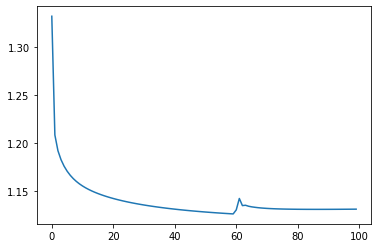

model score:  0.5501434533124674


In [50]:
picindextoclass = {}

for picclass in picclasses.keys():
    picindextoclass[picclasses[picclass]] = picclass

M = 30  # hidden units

model = ANN(M)
model.fit(X, Y, show_fig=True, epochs=1000, showeveryXrecords=10)
print('model score: ', model.score(X, Y))


In [46]:
choices = []
forhomework = []
hwanswers = []
mychoice = randint(0, X.shape[0] - 1)
forhomework.append(X[mychoice])
hwanswers.append(Y[mychoice])
choices.append(mychoice)
while mychoice in choices:
    mychoice = randint(0, X.shape[0] - 1)
choices.append(mychoice)
forhomework.append(X[mychoice])
hwanswers.append(Y[mychoice])

forhomework = np.asarray(forhomework)

hwpredictions = model.predict(forhomework)

for pred, ans in zip(hwpredictions, hwanswers):
    print('predicted ', pred, ' and was actually ', ans)

predicted  3  and was actually  3.0
predicted  3  and was actually  2.0
